# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf

## Functions

In [2]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10*10e-3 * Fs)

    return P, voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [4]:
x, Fs= sf.read(file_path)

In [5]:
IPython.display.Audio(file_path)

In [6]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

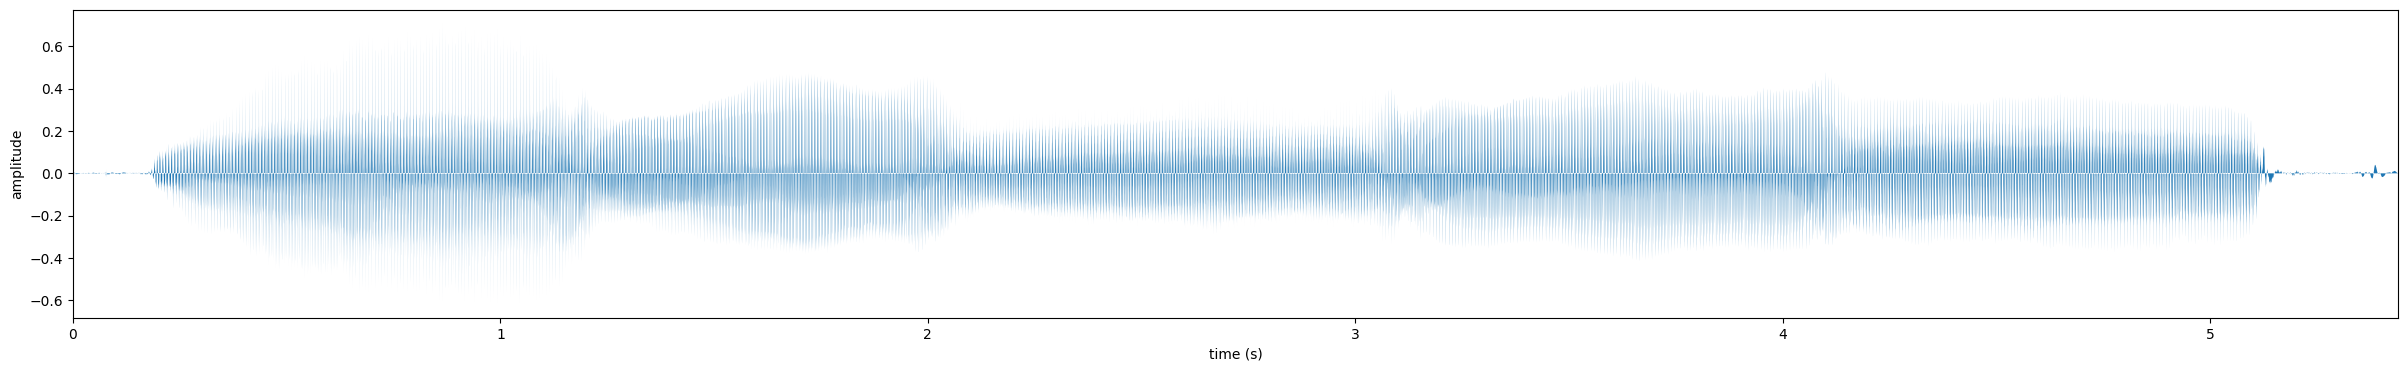

In [7]:
plot_sound(x, times)

In [8]:
sf.write('new_aeiou.wav',x, samplerate=Fs) # to write a new wave file

    1. Extraction of the analysis marks

Remark : we should always work with t as indexes, in this case at least.

In [9]:
def AnalysisPitchMarks(s,Fs):
    A = np.zeros((3, len(s)))
    n = 1
    # init
    A[0, 0] = 0
    A[2, 0] = 10*10e-3 * Fs

    # recursion
    while(True):
        t = A[0, n-1]
        duration = 2.5 * A[2, n-1]
        extracted_window = x[int(t): int(t+ duration)]

        A[2, n], A[1, n] = period(extracted_window, Fs)
        
        next_t = int(t + A[2, n])
        if(next_t >= len(s)):        # break when exceed time window
            break

        A[0, n] = next_t
        n+=1
        
    return A[:,:n]

In [10]:
A = AnalysisPitchMarks(x, Fs)
A

array([[0.0000e+00, 7.8000e+01, 1.1800e+03, ..., 5.7369e+04, 5.8471e+04,
        5.9573e+04],
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.1025e+03, 7.8000e+01, 1.1020e+03, ..., 1.1020e+03, 1.1020e+03,
        1.1020e+03]])

    2. Synthesis and modification of the temporal and spectral scales

synthesis without modification

In [11]:
print(len([i for i in range(1, len(A[0, :]))]))

656


In [12]:
B = np.zeros((2, len(A[0, :])))

B[0, :] = A[0, :]
B[1, :] = [i for i in range(1, len(A[0, :])+1)]

B

array([[0.0000e+00, 7.8000e+01, 1.1800e+03, ..., 5.7369e+04, 5.8471e+04,
        5.9573e+04],
       [1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 6.5500e+02, 6.5600e+02,
        6.5700e+02]])

This is a synthesis because we want to know the times of the shanks (where to put them), and the index of the chanks (which shank to put). 

2.1 Signal synthesis

In [13]:
# function y = Synthesis(s,Fs,A,B)
import scipy
def Synthesis(s, Fs, A, B):
    # init y 
    # zero vector of dimension ts(kend) + Pa(n(kend))
    y = np.zeros(int(A[0:len(A[0,:]) -1] + A[2:len(A[0,:]) -1]))

    k = 1
    while(k <= len(A[0,:])):
        # extract window centered on s
        t = A[0, k]
        duration = 2 * A[2, k] + 1
        extracted_seq = s[t - duration: t + duration]
        
        # windowing
        window = scipy.signal.hanning(len(extracted_seq))
        windowed_sig = extracted_seq * window

        # overlap-add
        y[t - duration: t + duration] += windowed_sig
    
    return y

In [14]:
y = Synthesis(x, Fs, A, B)

plot_sound(y, times)

TypeError: only length-1 arrays can be converted to Python scalars